In [2]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datasets import load_from_disk

# ----------------------------
# 1) utilities: steplog order
# ----------------------------
def load_steplog_idx_token(steplog_path: str):
    """
    steplog_path: path to a directory created by Dataset.save_to_disk(...)
                 (recommended), or a torch-saved object (fallback).
    Returns: idx_token list in step order.
    """
    if os.path.isdir(steplog_path):
        ds = load_from_disk(steplog_path)
        if "idx_token" not in ds.column_names:
            raise ValueError(f"'idx_token' not found in {steplog_path}. columns={ds.column_names}")
        return list(ds["idx_token"])

    # Fallback: if you saved with torch.save(...)
    obj = torch.load(steplog_path, map_location="cpu")
    if isinstance(obj, dict) and "idx_token" in obj:
        return list(obj["idx_token"])
    try:
        return list(obj["idx_token"])
    except Exception as e:
        raise ValueError(f"Cannot read idx_token from steplog file: {steplog_path}") from e


def unmask_order_from_idx_token(idx_token_list, prompt_len=64, gen_len=128):
    """
    Build a permutation 'order' of length gen_len (0..gen_len-1),
    sorted by the first step each generated token index appears in idx_token_list.
    idx_token in steplog is absolute in [0..prompt_len+gen_len-1], generated range is [prompt_len..prompt_len+gen_len-1].
    """
    lo = prompt_len
    hi = prompt_len + gen_len - 1

    first_step = {}
    for step, abs_idx in enumerate(idx_token_list):
        if lo <= abs_idx[0] <= hi:
            pos = abs_idx[0] - prompt_len  # 0..gen_len-1
            if pos not in first_step:
                first_step[pos] = step

    # ensure full permutation even if some positions missing
    missing = [p for p in range(gen_len) if p not in first_step]
    for p in missing:
        first_step[p] = 10**12 + p

    order = sorted(range(gen_len), key=lambda p: first_step[p])
    ordered_abs_idx = [prompt_len + p for p in order]  # for tick labels if desired
    return order, ordered_abs_idx


# ----------------------------
# 2) utilities: load K/V
# ----------------------------
def step_to_block(step, block_size=32, block_id_base=1):
    block_idx0 = step // block_size
    step_block = step % block_size
    block_id = block_idx0 + block_id_base
    return block_id, step_block


def load_kv_tensor(path):
    obj = torch.load(path, map_location="cpu")
    if torch.is_tensor(obj):
        return obj
    if isinstance(obj, dict):
        for key in ["k", "v", "key", "value", "K", "V"]:
            if key in obj and torch.is_tensor(obj[key]):
                return obj[key]
    raise TypeError(f"Unrecognized content in {path}: {type(obj)}")


def load_step_layer_tensor(records_dir, sample_id, layer, kind, step,
                           block_size=32, block_id_base=1):
    block_id, step_block = step_to_block(step, block_size, block_id_base)
    fname = f"batch_{sample_id}_{block_id}_{step_block}_{layer}_{kind}.pt"
    fpath = os.path.join(records_dir, fname)
    if not os.path.exists(fpath):
        raise FileNotFoundError(f"Missing file: {fpath}")

    T = load_kv_tensor(fpath)

    # allow [1, seq, hidden]
    if T.ndim == 3 and T.shape[0] == 1:
        T = T[0]

    # expected [seq, hidden]
    if T.ndim != 2:
        raise ValueError(f"Expected [seq, hidden], got {tuple(T.shape)} in {fpath}")

    return T.detach().float()  # float32 cpu


# ----------------------------
# 3) compute diff heatmap
# ----------------------------
def make_step_pairs(total_steps: int, pair_mode: str = "neighbor"):
    """
    pair_mode:
      - "neighbor": (0,1),(1,2),...,(T-2,T-1)
      - "nonoverlap": (0,1),(2,3),(4,5),...
    """
    if pair_mode == "neighbor":
        return [(t-1, t) for t in range(1, total_steps)]
    if pair_mode == "nonoverlap":
        return [(t, t+1) for t in range(0, total_steps-1, 2)]
    raise ValueError(f"Unknown pair_mode: {pair_mode}")


def cosine_sim_per_token(A, B):
    # A, B: [seq, hidden] -> [seq]
    return F.cosine_similarity(A, B, dim=1, eps=1e-8)


def layer_diff_step_pair_heatmap(
    records_dir: str,
    sample_id: int,
    kind: str,                 # "k" or "v"
    layer1: int,
    layer2: int,
    total_steps: int = 128,
    pair_mode: str = "neighbor",
    block_size: int = 32,
    block_id_base: int = 1,
):
    pairs = make_step_pairs(total_steps, pair_mode=pair_mode)

    # infer seq_len from first tensor
    ta, tb = pairs[0]
    T0 = load_step_layer_tensor(records_dir, sample_id, layer1, kind, ta,
                                block_size=block_size, block_id_base=block_id_base)
    seq_len, _ = T0.shape

    diff = torch.empty((len(pairs), seq_len), dtype=torch.float32)

    for i, (ta, tb) in enumerate(pairs):
        L1_a = load_step_layer_tensor(records_dir, sample_id, layer1, kind, ta,
                                      block_size=block_size, block_id_base=block_id_base)
        L1_b = load_step_layer_tensor(records_dir, sample_id, layer1, kind, tb,
                                      block_size=block_size, block_id_base=block_id_base)
        L2_a = load_step_layer_tensor(records_dir, sample_id, layer2, kind, ta,
                                      block_size=block_size, block_id_base=block_id_base)
        L2_b = load_step_layer_tensor(records_dir, sample_id, layer2, kind, tb,
                                      block_size=block_size, block_id_base=block_id_base)

        sim1 = cosine_sim_per_token(L1_b, L1_a)  # [seq]
        sim2 = cosine_sim_per_token(L2_b, L2_a)  # [seq]
        diff[i] = sim2 - sim1                    # [seq]

    return diff, pairs  # diff: [num_pairs, seq_len]


# ----------------------------
# 4) reorder x-axis by unmask order (gen tokens only)
# ----------------------------
def reorder_heatmap_by_unmask(diff, order, prompt_len=64, gen_len=128):
    """
    diff can be:
      - [num_pairs, 192] full seq (prompt+gen)
      - [num_pairs, 128] gen-only
    Returns reordered gen-only heatmap: [num_pairs, 128]
    """
    if diff.shape[1] == gen_len:
        diff_gen = diff
    elif diff.shape[1] == prompt_len + gen_len:
        diff_gen = diff[:, prompt_len:prompt_len+gen_len]
    else:
        raise ValueError(f"Unexpected seq_len={diff.shape[1]}; expected {gen_len} or {prompt_len+gen_len}")

    diff_reordered = diff_gen[:, order]
    return diff_reordered


# ----------------------------
# 5) plot
# ----------------------------
def plot_diff_heatmap_reordered(diff_reordered, pairs, ordered_abs_idx,
                               title="", savepath=None, symmetric=True, arbitrary=True):
    """
    diff_reordered: [num_pairs, 128] gen-only reordered by unmask order
    ordered_abs_idx: absolute token indices (64..191) in the x-order
    """
    if arbitrary:
        vmax = 0.2
    else:
        vmax = float(torch.max(torch.abs(diff_reordered)).item())
    # end

    if symmetric:
        vmin = -vmax
    else:
        vmin = float(diff_reordered.min().item())
        vmax = float(diff_reordered.max().item())

    plt.figure(figsize=(10, 6), dpi=150)
    im = plt.imshow(diff_reordered.numpy(), aspect="auto", cmap="RdYlGn", vmin=vmin, vmax=vmax)
    plt.colorbar(im, fraction=0.046, pad=0.04, label="(layer2 - layer1) cosine-sim diff")

    plt.xlabel("token (reordered by unmask sequence)")
    plt.ylabel("step pair (tb vs ta)")

    # y tick labels (sparse)
    if len(pairs) <= 16:
        yticks = list(range(len(pairs)))
    else:
        stride = max(1, len(pairs) // 8)
        yticks = list(range(0, len(pairs), stride))
    plt.yticks(yticks, [f"{pairs[i][1]} vs {pairs[i][0]}" for i in yticks])

    # x tick labels (sparse)
    L = len(ordered_abs_idx)
    stride_x = max(1, L // 10)
    xticks = list(range(0, L, stride_x))
    plt.xticks(xticks, [str(ordered_abs_idx[i]) for i in xticks], rotation=45)

    plt.title(title)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    plt.show()





/home/exx/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


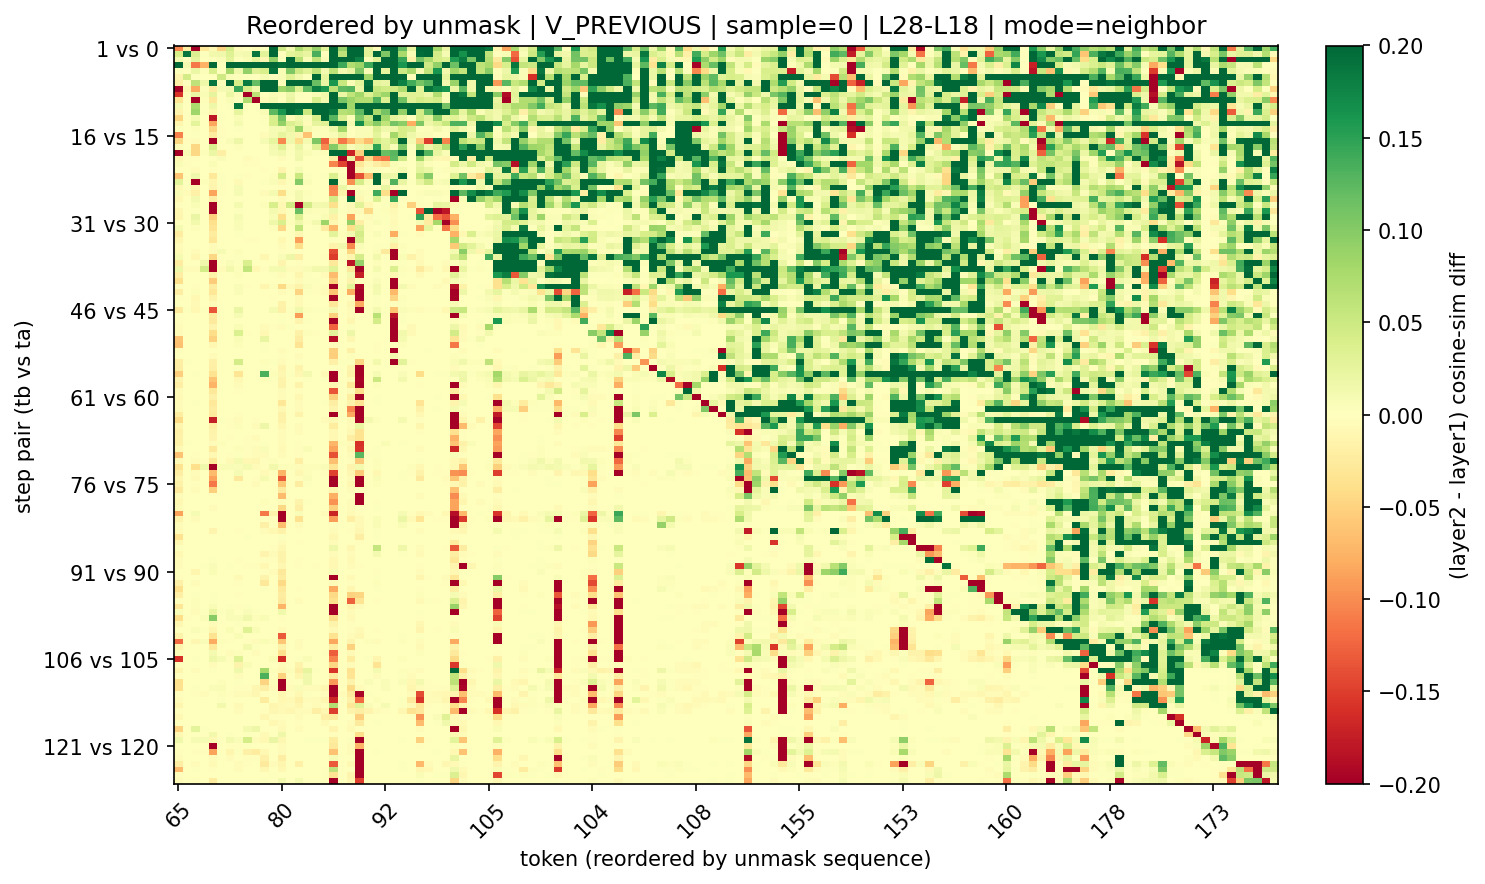

In [8]:
# ----------------------------
# 6) USAGE
# ----------------------------
if __name__ == "__main__":
    # Paths
    records_dir = "kv_states_20260219_consistency"                 # where batch_*.pt lives

    # Settings
    sample_id = 0
    steplog_dir_or_file = f'{records_dir}/{sample_id}.steplog'
    kind = "v_previous"              # "k" or "v"
    
    layer1 = 18
    layer2 = 28

    prompt_len = 64
    gen_len = 128
    total_steps = 128

    pair_mode = "neighbor"  # or "nonoverlap"
    block_size = 32
    block_id_base = 0       # matches your filename example

    # 1) build step-pair diff heatmap on full seq or gen-only (depends on saved tensors)
    diff, pairs = layer_diff_step_pair_heatmap(
        records_dir=records_dir,
        sample_id=sample_id,
        kind=kind,
        layer1=layer1,
        layer2=layer2,
        total_steps=total_steps,
        pair_mode=pair_mode,
        block_size=block_size,
        block_id_base=block_id_base,
    )

    # 2) load unmask sequence and build reorder index (gen tokens 64..191)
    idx_token_list = load_steplog_idx_token(steplog_dir_or_file)
    order, ordered_abs_idx = unmask_order_from_idx_token(
        idx_token_list, prompt_len=prompt_len, gen_len=gen_len
    )

    # 3) reorder x-axis (gen-only) by unmask order
    diff_reordered = reorder_heatmap_by_unmask(diff, order, prompt_len=prompt_len, gen_len=gen_len)

    # 4) plot
    plot_diff_heatmap_reordered(
        diff_reordered,
        pairs,
        ordered_abs_idx,
        title=f"Reordered by unmask | {kind.upper()} | sample={sample_id} | L{layer2}-L{layer1} | mode={pair_mode}",
        savepath=f"diff_reordered_{kind}_b{sample_id}_L{layer2}-L{layer1}_{pair_mode}.png",
        symmetric=True,
    )